# Data Loading and Initial Inspection

In [1]:
!pip install scikit-optimize

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from google.colab import drive
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import matplotlib.pyplot as plt

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Define file paths
training1_path = '/content/drive/My Drive/training1.csv'
training2_path = '/content/drive/My Drive/training2.csv'
test_data_path = '/content/drive/My Drive/test.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load data into DataFrames
training1 = pd.read_csv(training1_path)
training2 = pd.read_csv(training2_path)
test_data = pd.read_csv(test_data_path)

# Print the shape of the datasets
print("Shape of training1:", training1.shape)
print("Shape of training2:", training2.shape)
print("Shape of test_data:", test_data.shape)

Shape of training1: (400, 3458)
Shape of training2: (2750, 3458)
Shape of test_data: (1000, 3456)


# Data Preprocessing

### Handling Missing Values with SimpleImputer

In [5]:
# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')

# all columns except 'label' and 'confidence'
features_training2 = training2.iloc[:, :-2]
features_imputed_training2 = imputer.fit_transform(features_training2)

# handling missing data for test data
features_imputed_test = imputer.transform(test_data)
labels_training2 = training2['label']

### Feature Scaling with StandardScaler

In [6]:
# Feature scaling
scaler = StandardScaler()
# scaling training1
features_scaled_training1 = scaler.fit_transform(training1.iloc[:, :-2])
# scaling training2
features_scaled_training2 = scaler.transform(features_imputed_training2)
# scaling test data
features_scaled_test = scaler.transform(features_imputed_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### Combining the Training Data

In [7]:
# Combine Training Data
X_training1 = features_scaled_training1
y_training1 = training1['label']
X_combined = np.vstack((X_training1, features_scaled_training2))
y_combined = np.concatenate((y_training1, training2['label']))
confidence_combined = np.concatenate((training1['confidence'], training2['confidence']))

print("Shape of combined training data:", X_combined.shape)
print("Shape of combined labels:", y_combined.shape)

Shape of combined training data: (3150, 3456)
Shape of combined labels: (3150,)


# Hyperparameter to determine the optimal parameters for the RandomForestClassifer

# Feature Selection based on Feature Importance

### Using BayesSearchCV

In [8]:
# Define the search space for BayesSearchCV
search_spaces = {
    'max_depth': Integer(3, 15),  # Narrowing down the range
    'max_features': Integer(3, 8),  # Narrowing down the range
    'min_samples_split': Integer(2, 10),  # Narrowing down the range
    'bootstrap': Categorical([True]),  # Focusing on True
    'n_estimators': Integer(50, 300)  # Narrowing down the range
}

# Define the classifier
rf_clf = RandomForestClassifier(random_state=42)

# Set up BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=rf_clf,
    search_spaces=search_spaces,
    n_iter=20,
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

In [9]:
# Use a subset of the data for hyperparameter tuning
X_sample, _, y_sample, _ = train_test_split(X_combined, y_combined, train_size=0.5, random_state=42)

# Fit BayesSearchCV to the data
bayes_search.fit(X_sample, y_sample)

# Best model from BayesSearchCV
best_rf = bayes_search.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [10]:
# Evaluate the best model without feature selection
X_train, X_val, y_train, y_val = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_val)
accuracy_baseline = accuracy_score(y_val, y_pred)

print(f"Random Forest Accuracy with BayesSearchCV: {accuracy_baseline}")
print("Random Forest Classification Report with BayesSearchCV:\n", classification_report(y_val, y_pred))

Random Forest Accuracy with BayesSearchCV: 0.7428571428571429
Random Forest Classification Report with BayesSearchCV:
               precision    recall  f1-score   support

         0.0       0.75      0.78      0.77       337
         1.0       0.74      0.70      0.72       293

    accuracy                           0.74       630
   macro avg       0.74      0.74      0.74       630
weighted avg       0.74      0.74      0.74       630



In [11]:
# Feature importances
importances = best_rf.feature_importances_

# Use SelectFromModel to automate feature selection
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(best_rf, prefit=True, threshold=-np.inf, max_features=250)
X_combined_selected_auto = selector.transform(X_combined)
features_scaled_test_selected_auto = selector.transform(features_scaled_test)

In [12]:
# Re-tune hyperparameters for the selected features
bayes_search_selected = BayesSearchCV(
    estimator=rf_clf,
    search_spaces=search_spaces,
    n_iter=20,
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

In [13]:
# Use a subset of the data for hyperparameter tuning on selected features
X_sample_selected, _, y_sample_selected, _ = train_test_split(X_combined_selected_auto, y_combined, train_size=0.3, random_state=42)

# Fit BayesSearchCV to the selected features data subset
bayes_search_selected.fit(X_sample_selected, y_sample_selected)

# Best model from BayesSearchCV with selected features
best_rf_selected = bayes_search_selected.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [14]:
# Evaluate the best model with feature selection on the full data
X_train_selected, X_val_selected, y_train_selected, y_val_selected = train_test_split(X_combined_selected_auto, y_combined, test_size=0.1, random_state=42)
best_rf_selected.fit(X_train_selected, y_train_selected)
y_pred_selected = best_rf_selected.predict(X_val_selected)
accuracy_selected = accuracy_score(y_val_selected, y_pred_selected)

print(f"Random Forest Accuracy with BayesSearchCV and Feature Selection: {accuracy_selected}")
print("Random Forest Classification Report with BayesSearchCV and Feature Selection:\n", classification_report(y_val_selected, y_pred_selected))


Random Forest Accuracy with BayesSearchCV and Feature Selection: 0.7682539682539683
Random Forest Classification Report with BayesSearchCV and Feature Selection:
               precision    recall  f1-score   support

         0.0       0.81      0.75      0.78       172
         1.0       0.72      0.79      0.76       143

    accuracy                           0.77       315
   macro avg       0.77      0.77      0.77       315
weighted avg       0.77      0.77      0.77       315



In [27]:
# Function to evaluate and return accuracy
def evaluate_model(model, X_train, y_train, X_val, y_val, sample_weight=None):
    model.fit(X_train, y_train, sample_weight=sample_weight)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy, classification_report(y_val, y_pred)

In [28]:
# Split data for evaluation
X_train_full, X_val_full, y_train_full, y_val_full = train_test_split(X_combined, y_combined, test_size=0.1, random_state=42)
X_train_incomplete, X_val_incomplete, y_train_incomplete, y_val_incomplete = train_test_split(features_scaled_training2, labels_training2, test_size=0.1, random_state=42)
X_train_complete, X_val_complete, y_train_complete, y_val_complete = train_test_split(features_scaled_training1, y_training1, test_size=0.1, random_state=42)

In [29]:
# Evaluate on different training sets
acc_full, report_full = evaluate_model(best_rf_selected, X_train_full, y_train_full, X_val_full, y_val_full)
acc_incomplete, report_incomplete = evaluate_model(best_rf_selected, X_train_incomplete, y_train_incomplete, X_val_incomplete, y_val_incomplete)
acc_complete, report_complete = evaluate_model(best_rf_selected, X_train_complete, y_train_complete, X_val_complete, y_val_complete)

print(f"Accuracy with Full Data: {acc_full}")
print(f"Classification Report with Full Data:\n{report_full}")

print(f"Accuracy with Incomplete Data: {acc_incomplete}")
print(f"Classification Report with Incomplete Data:\n{report_incomplete}")

print(f"Accuracy with Complete Data: {acc_complete}")
print(f"Classification Report with Complete Data:\n{report_complete}")

Accuracy with Full Data: 0.7714285714285715
Classification Report with Full Data:
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79       172
         1.0       0.75      0.75      0.75       143

    accuracy                           0.77       315
   macro avg       0.77      0.77      0.77       315
weighted avg       0.77      0.77      0.77       315

Accuracy with Incomplete Data: 0.72
Classification Report with Incomplete Data:
              precision    recall  f1-score   support

         0.0       0.70      0.75      0.72       134
         1.0       0.75      0.69      0.72       141

    accuracy                           0.72       275
   macro avg       0.72      0.72      0.72       275
weighted avg       0.72      0.72      0.72       275

Accuracy with Complete Data: 0.775
Classification Report with Complete Data:
              precision    recall  f1-score   support

         0.0       0.83      0.79      0.81        2

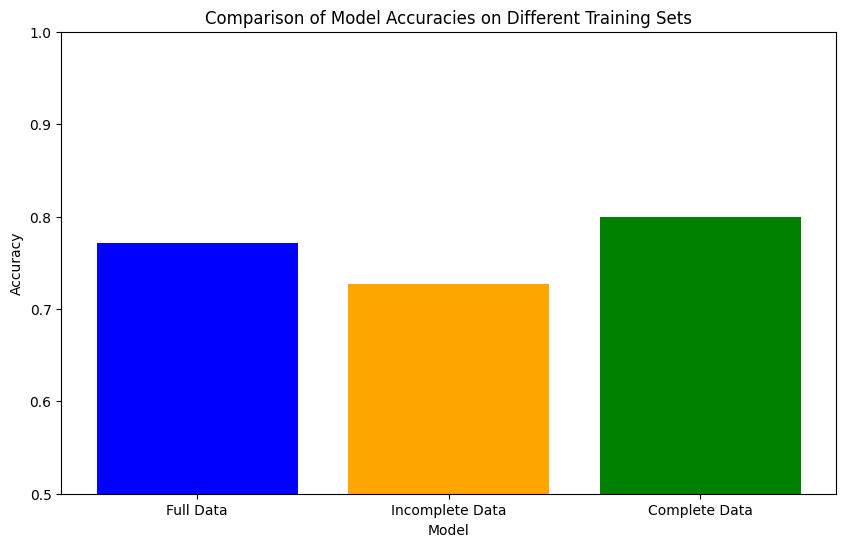

In [19]:
# Compare model performance
accuracy_scores = [acc_full, acc_incomplete, acc_complete]
model_names = ['Full Data', 'Incomplete Data', 'Complete Data']

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_scores, color=['blue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies on Different Training Sets')
plt.ylim(0.5, 1.0)
plt.show()

In [20]:
# Evaluate with confidence labels
acc_full_conf, report_full_conf = evaluate_model(rf_clf, X_train_full, y_train_full, X_val_full, y_val_full, sample_weight=confidence_combined[:X_train_full.shape[0]])

print(f"Accuracy with Full Data and Confidence: {acc_full_conf}")
print(f"Classification Report with Full Data and Confidence:\n{report_full_conf}")


Accuracy with Full Data and Confidence: 0.7619047619047619
Classification Report with Full Data and Confidence:
              precision    recall  f1-score   support

         0.0       0.79      0.77      0.78       172
         1.0       0.73      0.76      0.74       143

    accuracy                           0.76       315
   macro avg       0.76      0.76      0.76       315
weighted avg       0.76      0.76      0.76       315



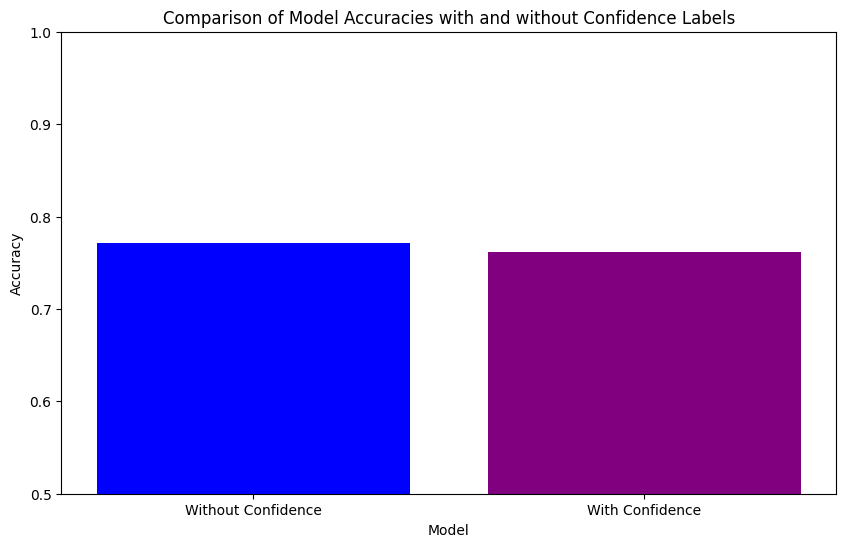

In [21]:
# Compare model performance with and without confidence labels
accuracy_scores_conf = [acc_full, acc_full_conf]
model_names_conf = ['Without Confidence', 'With Confidence']

plt.figure(figsize=(10, 6))
plt.bar(model_names_conf, accuracy_scores_conf, color=['blue', 'purple'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies with and without Confidence Labels')
plt.ylim(0.5, 1.0)
plt.show()


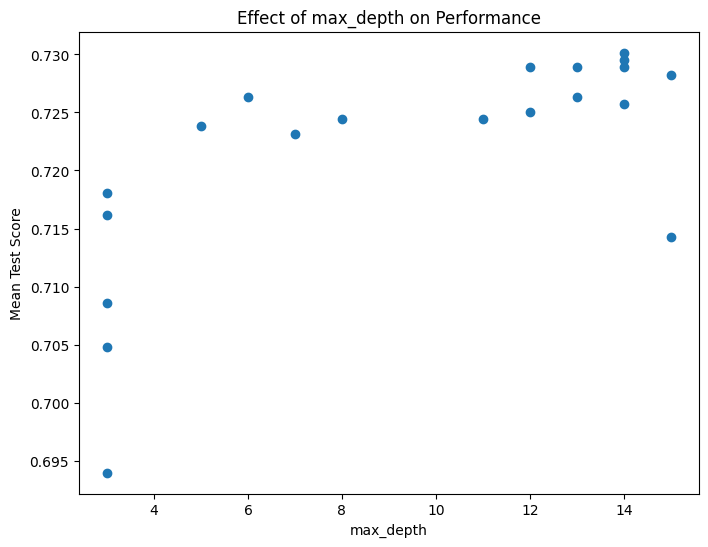

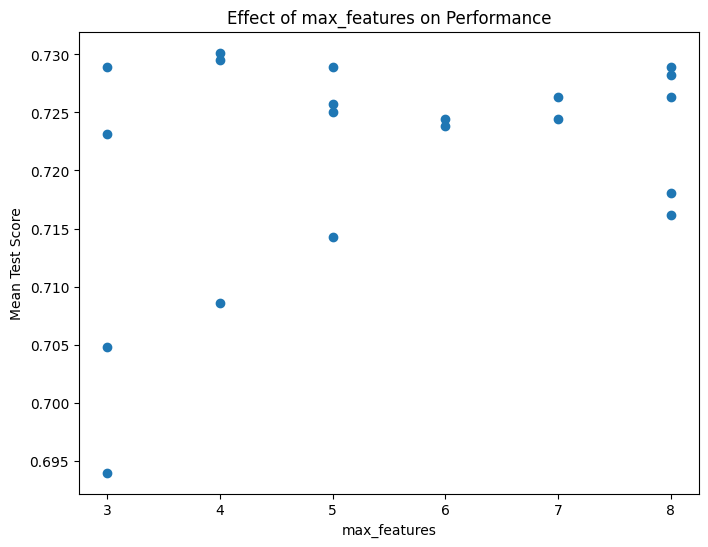

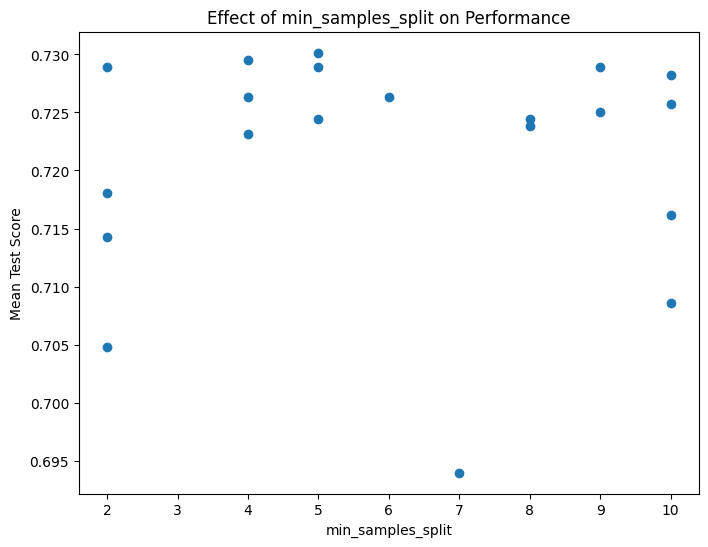

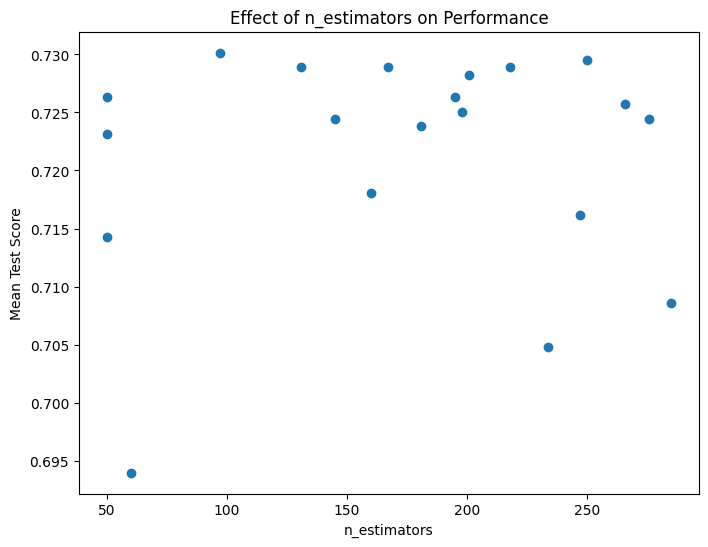

In [22]:
# Visualize results from BayesSearchCV
results = pd.DataFrame(bayes_search.cv_results_)

# Plot the effect of each hyperparameter
def plot_hyperparameter_effects(param_name, results):
    plt.figure(figsize=(8, 6))
    plt.scatter(results['param_' + param_name], results['mean_test_score'])
    plt.xlabel(param_name)
    plt.ylabel('Mean Test Score')
    plt.title(f'Effect of {param_name} on Performance')
    plt.show()

plot_hyperparameter_effects('max_depth', results)
plot_hyperparameter_effects('max_features', results)
plot_hyperparameter_effects('min_samples_split', results)
plot_hyperparameter_effects('n_estimators', results)

In [35]:
# Train the model on the complete training data
best_rf_selected.fit(X_train_complete, y_train_complete)

# Evaluate the model on the validation set
y_pred_complete = best_rf_selected.predict(X_val_complete)
accuracy_complete = accuracy_score(y_val_complete, y_pred_complete)
classification_report_complete = classification_report(y_val_complete, y_pred_complete)

print(f"Accuracy with Complete Data: {accuracy_complete}")
print(f"Classification Report with Complete Data:\n{classification_report_complete}")

Accuracy with Complete Data: 0.775
Classification Report with Complete Data:
              precision    recall  f1-score   support

         0.0       0.83      0.79      0.81        24
         1.0       0.71      0.75      0.73        16

    accuracy                           0.78        40
   macro avg       0.77      0.77      0.77        40
weighted avg       0.78      0.78      0.78        40



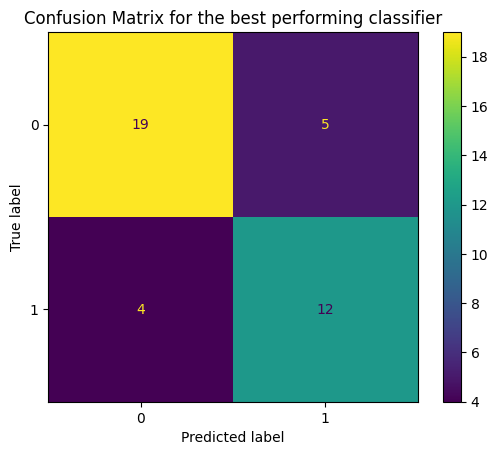

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc

# Confusion Matrix for the best performing classifier
cm = confusion_matrix(y_val_complete, y_pred_complete)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix for the best performing classifier")
plt.show()

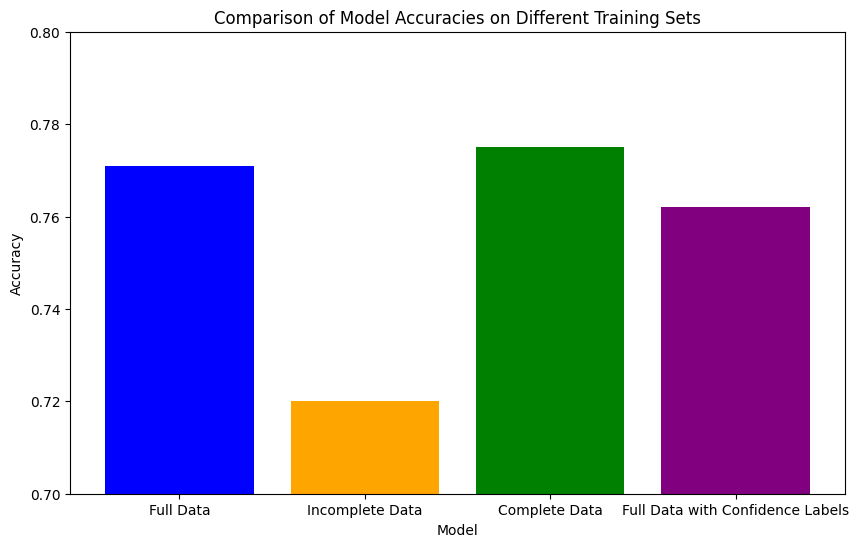

In [43]:
# Define the model names and their corresponding accuracies
model_names = ['Full Data', 'Incomplete Data', 'Complete Data', 'Full Data with Confidence Labels']
accuracies = [0.771, 0.720, 0.775, 0.762]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'orange', 'green', 'purple'])

# Add titles and labels
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies on Different Training Sets')
plt.ylim(0.7, 0.8)


# Display the plot
plt.show()


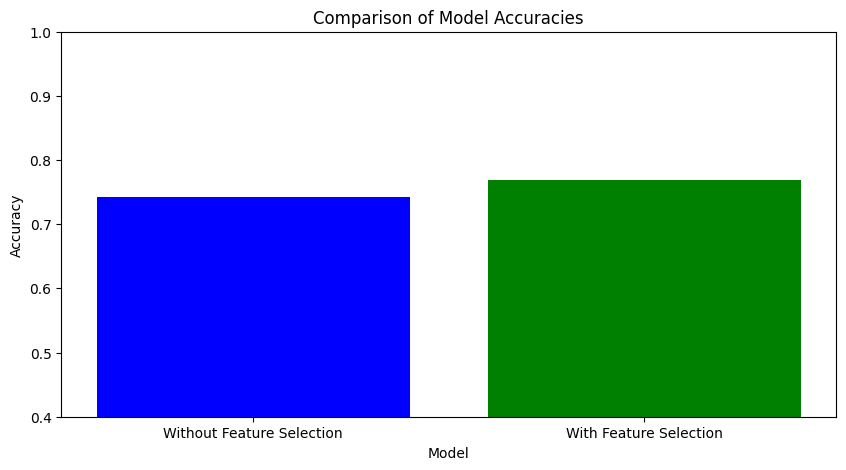

In [47]:
# Compare model performance with and without feature selection
accuracy_scores_fs = [accuracy_baseline, accuracy_selected]
model_names_fs = ['Without Feature Selection', 'With Feature Selection']

plt.figure(figsize=(10, 5))
plt.bar(model_names_fs, accuracy_scores_fs, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0.4, 1.0)
plt.show()


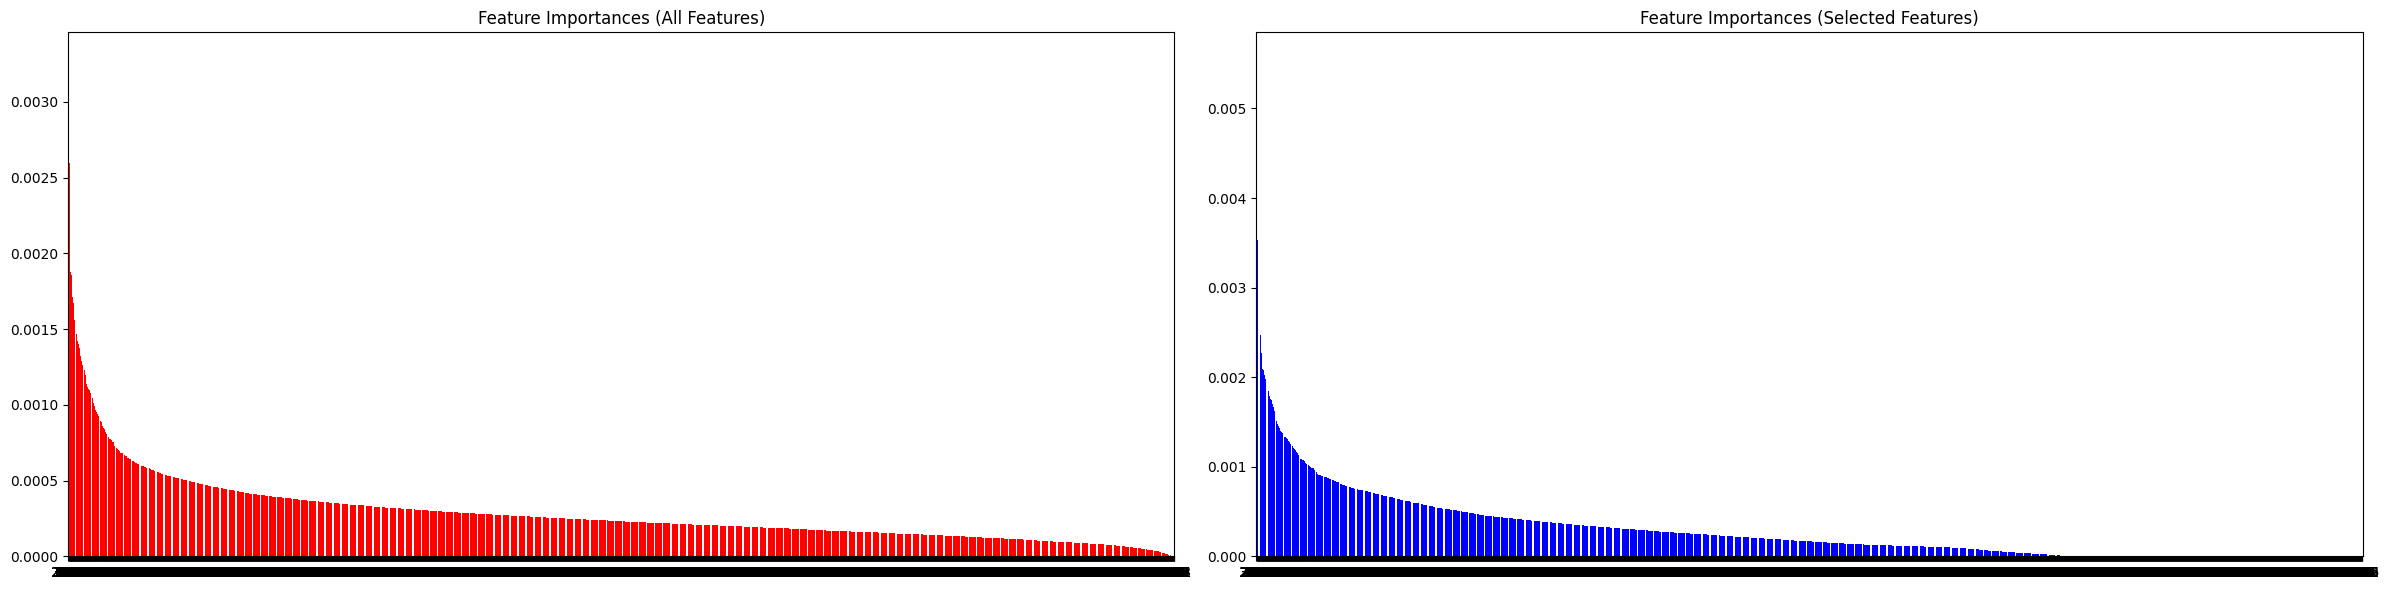

In [38]:
# Feature Importances for the best model without feature selection
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Feature Importances for the best model with feature selection
importances_selected = best_rf_selected.feature_importances_
indices_selected = np.argsort(importances_selected)[::-1]

# Plotting side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

# Plot for the best model without feature selection
axes[0].bar(range(len(importances)), importances[indices], color='r', align='center')
axes[0].set_title('Feature Importances (All Features)')
axes[0].set_xticks(range(len(importances)))
axes[0].set_xticklabels(indices)
axes[0].set_xlim([-1, len(importances)])

# Plot for the best model with feature selection
axes[1].bar(range(len(importances_selected)), importances_selected[indices_selected], color='b', align='center')
axes[1].set_title('Feature Importances (Selected Features)')
axes[1].set_xticks(range(len(importances_selected)))
axes[1].set_xticklabels(indices_selected)
axes[1].set_xlim([-1, len(importances_selected)])

plt.tight_layout()
plt.show()


In [40]:
# Making predictions on the test set
# Make predictions with the best model after feature selection
test_predictions = best_rf_selected.predict(features_scaled_test)

df_test_predictions = pd.DataFrame(test_predictions, columns=['prediction'])

#Save the predictions to a csv FILE WITHOUT THE INdex
df_test_predictions.to_csv('predictions.csv', index=False)

#Display the file in the Files section
from google.colab import files
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>